### Momentum, Mean Reversion and the Uncovered Interest Rate Parity [(UIP)](https://www.investopedia.com/terms/u/uncoveredinterestrateparity.asp) in FX Markets
+ Exchange rate movements should reflect changes in interest rates between currencies
+ Using Fama and French as basis a model of log returns was created by [Balvers and Wu](https://pdfs.semanticscholar.org/c98c/533334b6962d06b44ae7a796b5fcffbe2fe4.pdf)
    + Price is the sum of a random walk process and a stationary component
    + stationary component represents temporary swings in price
    + There is also a drift component and a momentum effect
    + The drift component p is allowed to change between equities in different countries
    + The momentum effect coefficient and temporary swings coefficient are held constant across countries
    + [Alina Serban](http://isiarticles.com/bundles/Article/pre/pdf/14874.pdf) adapted that research to the forex market 
    + Additional paper by [Fama](https://eml.berkeley.edu/~craine/EconH195/Fall_13/webpage/Fama_Forward%20Discount.pdf)
    
    
##### Serban Paper tries to find a pattern in the deviation from UIP.
+ Mean Reversion and Momentum are two key characteristics
+ Long run mean reversion in currencies by [Engel and Hamilton](https://econpapers.repec.org/article/aeaaecrev/v_3a80_3ay_3a1990_3ai_3a4_3ap_3a689-713.htm)
+ [Short-term momentum affects](https://econpapers.repec.org/article/cupjfinqa/v_3a38_3ay_3a2003_3ai_3a02_3ap_3a425-447_5f00.htm) 
+ Combining these two ideas [Chiang and Jiang](chrome-extension://oemmndcbldboiebfnladdacbdfmadadm/http://isiarticles.com/bundles/Article/pre/pdf/14874.pdf#%5Bnull%2C%7B%22name%22%3A%22FitR%22%7D%2C29%2C794%2C596%2C794%5D) notice the strong correlations in the short-run (momentum) and negative correlation in the long-run (mean-reversion)

#### The Serban paper combines these two momentum and mean reversion anomolies in a trading strategy

In [1]:
from math import floor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import TimeSeriesSplit
from sklearn import tree
import datetime as datetime


import quandl as ql
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import talib

%matplotlib inline


key = ''

#### Get our data
+ We'll use quandl FRED database to get currencies from 2004 to the present
+ I added AUD/USD which is not present in the original paper
+ We use xarray to concat the data into a single dataset indexed by date and currency pair

In [2]:

# pairs = dict(eur_usd="FRED/DEXUSEU", 
#              aus_usd='FRED/DEXUSAL', 
#              usd_gbp='FRED/DEXUSUK',
#              cad_usd='FRED/DEXCAUS',
#              jpy_usd='FRED/DEXJPUS',
#             )
# das = []
# for k, v in pairs.items():
#     data = ql.get(v, start_date='2004-01-01', end_date='2019-01-14', api_key=key)
#     das.append(xr.DataArray(data, coords=[data.index, [k]], dims=['Date', 'currency_pair']))
# ds_currency = xr.concat(das, dim='currency_pair').to_dataset(name='price')      
# ds_currency.to_zarr('currency_pairs_uip', 'w')

In [3]:
ds_currency = xr.open_zarr('currency_pairs_uip')

In [4]:
#Lets make sure we don't have any nans
ds_currency['price'].isnull().values.sum()

0

#### Format the data according to paper spec
+ Calculate monthly log returns
+ Calculate a reversal and momentum factor 

In [5]:
df_currency = ds_currency.to_dataframe().unstack(level=1)
df_currency.columns = df_currency.columns.droplevel(0)
df_currency = df_currency.rename_axis(None, axis=1)
df_currency.head()

,aus_usd,cad_usd,eur_usd,jpy_usd,usd_gbp
Date,,,,,
2004-01-02,0.7576,1.2900,1.2592,106.95,1.7902
2004-01-05,0.7682,1.2803,1.2679,106.10,1.8085
2004-01-06,0.7702,1.2824,1.2773,106.20,1.8245
2004-01-07,0.7685,1.2884,1.2665,106.19,1.8193
2004-01-08,0.7755,1.2790,1.2772,106.17,1.8338




#### Algorithm Setup
+ cycle through each of the pairs
+ Construct your currency_pair xs and ys
+ Perform training,test split and OLS
+ Get a prediction
+ Construct a date by currency pair matrix with prediction as the value
+ Every time we have some condition then we trade


In [6]:
def compute_returns(period_df, pair):
    logged = np.log(1 + period_df.pct_change()).rename({pair: 'log_returns'})
    return logged

def compute_reversal(period_df, period, mu, sigma):
    
    reversal = (period_df.shift(period) - mu)/sigma
    return reversal

def compute_momentum(period_df, lag_start, lag_end):
    momentum = period_df.shift(lag_start) - period_df.shift(lag_end)
    return momentum

def compute_factors(df,pair):
    '''
    Computes momentum and mean reversal factors 
    as well as log returns for each currency pair and period
    
    Parameters
    ==========
    df: pd.Dataframe of date by currency price
    
    
    Returns
    =======
    tuple of monthly data, mu, sigma and factor and returns dataframe
    
    '''
    
    mu = df.mean()
    sigma = df.std()
    
    df_monthly = df.resample('BM').apply(lambda x: x[-1])
    
    logged = np.log(1 + df_monthly.pct_change()).rename({pair: 'log_returns'})
    reversal = (df_monthly.shift(1) - mu)/sigma
    momentum = df_monthly.shift(1) - df_monthly.shift(4)
    
    ctd = pd.concat([reversal,momentum,logged],axis=1)
    ctd.columns  = ['reversal', 'momentum', 'logged_returns']
    ctd = ctd.dropna()
    
    return ctd


def compute_OLS(df, pair):
    '''
    Parameters
    ==========
    df: pd.Dataframe of period by currency_pair
    pair: str of currency pair
    
    
    Returns
    =======
    dictionary of pd.Series of predicted returns and sklearn.LinearRegression fitted model
    
    
    '''
    split = -int(len(df)/3)
    train = df[:split]
    test = df[split:]
    
    X = df[['reversal', 'momentum']]
    y = df[['logged_returns']]
    
    X_train, X_test,  y_train, y_test = X[:split], X[split:], y[:split], y[split:]
    
    model = LinearRegression()
    model.fit(X_train,y_train)
    model.predict(X_test)
    pred_returns = pd.Series(model.predict(X_test).flatten(), index=y_test.index, name=pair)
    
    return {'returns':pred_returns, 'model': model}
    
def generate_predictions(currency_df):
    '''
    Calls factor generation and trade prediction routines
    and constructs a dataframe of predicted returns 
    for each period and currency pair
    
    Final return dataframe is for an out of sample period only
        
    Parameters
    ==========
    currency_df: pd.DataFrame of period by currency pair
    
    Returns
    =======
    pd.DataFrame of period by currency pair
    '''
    
    rets_list = []
    for i in df_currency.columns:
        df = df_currency[i]
        #go through each column and generate a set of factors and predicted returns
        res = compute_factors(df, i)
        rets_list.append(compute_OLS(res, i)['returns'])
    
    return pd.concat(rets_list, axis=1)  


def generate_trades(predictions_df):
    '''
    Takes a dataframe of period returns by currency pair
    sorts them from highest to lowest and then assigns a value of 
    1/-1 to the highest/lowest values for each period. 
    
    Long/short positions are not required. If the worst performing of 
    the period is positive, only a long is taken. Similarly, if all 
    period returns were negative only the most negative receives is marked 
    -1, indicating a short position. 
    
    The trades are generated for the out of sample period. 
    
    Parameters
    ==========
    predictions_df: pd.DataFrame of period by currency pair 
    
    
    Returns
    =======
    pd.DataFrame of period by currency pair
    '''
    trades = []
    for i, row in predictions_df.iterrows():
        _sorted = row.sort_values(axis=0,ascending=False)
        #for condition that they the long is positive and the short is negative
        if _sorted[0]*_sorted[-1] < 0:
            trade = {_sorted.index[0]: 1,_sorted.index[-1]: -1}

        elif _sorted[0] and _sorted[-1] > 0:
            trade = {_sorted.index[0]: 1}

        else: 
            trade = {_sorted.index[-1]: -1}
        trades.append(trade)
        
    return pd.DataFrame(trades, index=predictions_df.index)

In [7]:
predictions = generate_predictions(df_currency)
trades = generate_trades(predictions)

In [8]:
actual_returns_test_period = df_currency.resample('BM').apply(lambda x: x[-1])[-60:]
pair_rets = []
for c in actual_returns_test_period.columns:
    pair_rets.append(compute_returns(actual_returns_test_period[c], c))
    
ctd_returns_test = pd.concat(pair_rets, axis=1)

In [9]:
return_status = ctd_returns_test[1:]*trades
return_status['summed'] = return_status.sum(axis=1)

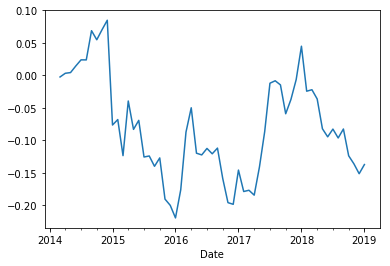

In [10]:
return_status['summed'].cumsum().plot()

In [11]:
resampled = df_currency.resample('BM').apply(lambda x: x[-1])

##### How does each perform? Let's try and figure out where the bad performance may be coming from.

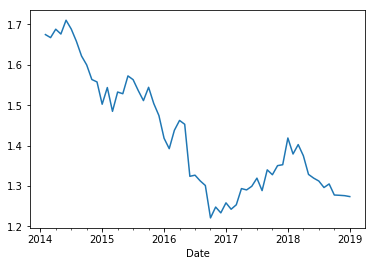

In [12]:
resampled['usd_gbp'][-60:].plot()

In [13]:
resampled.columns

Index(['aus_usd', 'cad_usd', 'eur_usd', 'jpy_usd', 'usd_gbp'], dtype='object')

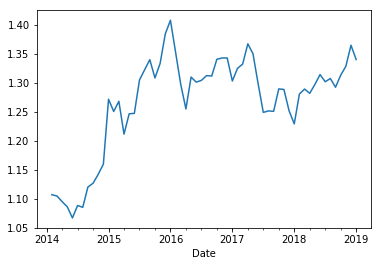

In [14]:
resampled['cad_usd'][-60:].plot()

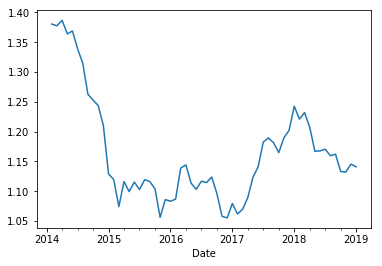

In [15]:
resampled['eur_usd'][-60:].plot()

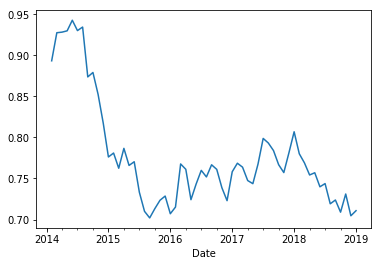

In [16]:
resampled['aus_usd'][-60:].plot()

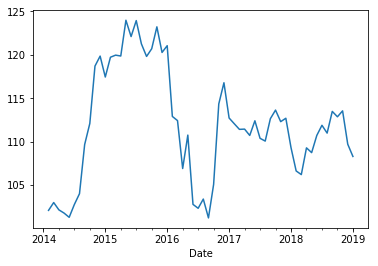

In [17]:
resampled['jpy_usd'][-60:].plot()